In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
import skimage.exposure
import pandas as pd

In [2]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
CLEANED = os.path.join(DIR, 'preps', 'CH1', 'thumbnail_cleaned')
MASKED = os.path.join(DIR, 'preps', 'thumbnail_masked')
files = sorted(os.listdir(INPUT))

In [9]:
def linnorm(img, limit, dt):
    flat = img.flatten()
    hist, bins = np.histogram(flat, limit + 1)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = limit * cdf / cdf[-1]  # normalize
    # use linear interpolation of cdf to find new pixel values
    img_norm = np.interp(flat, bins[:-1], cdf)
    img_norm = np.reshape(img_norm, img.shape)
    return img_norm.astype(dt)

def get_index(array, list_of_arrays):
    for j, a in enumerate(list_of_arrays):
        if np.array_equal(array, a):
            return j
    return None


def find_main_blob(stats, image):
    height, width = image.shape
    df = pd.DataFrame(stats)
    df.columns = ['Left', 'Top', 'Width', 'Height', 'Area']
    df['blob_label'] = df.index
    df = df.sort_values(by='Area', ascending=False)

    for row in df.iterrows():
        Left = row[1]['Left']
        Top = row[1]['Top']
        Width = row[1]['Width']
        Height = row[1]['Height']
        corners = int(Left == 0) + int(Top == 0) + int(Width == width) + int(Height == height)
        if corners <= 2:
            return row


def scale_and_mask(src, mask, epsilon=0.01):
    vals = np.array(sorted(src[mask > 10]))
    ind = int(len(vals) * (1 - epsilon))
    _max = vals[ind]
    # print('thr=%d, index=%d'%(vals[ind],index))
    _range = 2 ** 16 - 1
    scaled = src * (45000. / _max)
    scaled[scaled > _range] = _range
    scaled = scaled * (mask > 10)
    return scaled, _max

def find_threshold(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0, 0, 0, 0))
    n, bins, patches = ax.hist(src.flatten(), 360);
    del ax, fig
    min_point = np.argmin(n[:5])
    min_point = int(min(2, min_point))
    thresh = (min_point * 64000 / 360) + 100
    return min_point, thresh

strip_max=70; strip_min=5   # the range of width for the stripe
def remove_strip(src):
    projection=np.sum(src,axis=0)/10000.
    diff=projection[1:]-projection[:-1]
    loc,=np.nonzero(diff[-strip_max:-strip_min]>50)
    mval=np.max(diff[-strip_max:-strip_min])
    no_strip=np.copy(src)
    fe = 0
    if loc.shape[0]>0:
        loc=np.min(loc)
        from_end=strip_max-loc
        fe = -from_end - 2
        no_strip[:,fe:]=0 # mask the strip
    return no_strip, fe

def find_contour_area(mask):
    area2 = 0
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    c1 = max(contours, key = cv2.contourArea)
    area1 = cv2.contourArea(c1)
    idx = get_index(c1, contours)  # 2
    contours.pop(idx)
    if len(contours) > 0:
        c2 = max(contours, key = cv2.contourArea)
        area2 = cv2.contourArea(c2)
    return area1 + area2


def fix_with_fill(img):

    no_strip, fe = remove_strip(img)
    if fe != 0:
        img[:,fe:]=0 # mask the strip
        
    img = (img/256).astype(dt)
    h_src = linnorm(img, limit , dt)
    med = np.median(h_src)
    h, im_th = cv2.threshold(h_src, med, limit, cv2.THRESH_BINARY)
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_th | im_floodfill_inv
        
    
    stencil = np.zeros(img.shape).astype('uint8')
    contours, hierarchy = cv2.findContours(im_out, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    totalarea = im_out.shape[0] * im_out.shape[1]
    
    lc = []
    c1 = max(contours, key = cv2.contourArea)
    lc.append(c1)
    area1 = cv2.contourArea(c1)
        
    area2 = 0
    idx = get_index(c1, contours)  # 2
    contours.pop(idx)
    if len(contours) > 0:
        c2 = max(contours, key = cv2.contourArea)
        area2 = cv2.contourArea(c2)
        area3 = area2 * 0.035
        if area2 > area3:
            lc.append(c2)
    cv2.fillPoly(stencil, lc, 255)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
    dilation = cv2.dilate(stencil,kernel,iterations = 2)
    return h_src, im_out, dilation, area1 + area2
    
def fix_with_blob(img):
    no_strip, fe = remove_strip(img)
    min_value, threshold = find_threshold(img)
    ret, threshed = cv2.threshold(no_strip, threshold, 255, cv2.THRESH_BINARY)
    threshed = np.uint8(threshed)
    connectivity = 4
    output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
    labels = output[1]
    stats = output[2]
    # Find the blob that corresponds to the section.
    if fe != 0:
        img[:,fe:]=0 # mask the strip
    row = find_main_blob(stats, img)
    blob_label = row[1]['blob_label']
    # extract the blob
    blob = np.uint8(labels == blob_label) * 255
    # Perform morphological closing
    kernel10 = np.ones((10, 10), np.uint8)
    #kernel10 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (26, 26))
    dilation = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
    return no_strip, blob, dilation
    

In [12]:
# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
imouts = []
masks = []
limit = 250
areas = []
dt = np.uint8
bads = ['091.tif','115.tif','130.tif','239.tif','267.tif','271.tif']
for i, file in enumerate(tqdm(files)):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    img_inputs.append(img)
    h_src, im_out, dilation = fix_with_blob(img)
    area = find_contour_area(dilation)
    if i > 0 and area < (areas[i-1] * 0.90):
        h_src, im_out, dilation, area = fix_with_fill(img)
    areas.append(area)
    file_inputs.append((file,area))
    img_outputs.append(h_src)
    imouts.append(im_out)
    masks.append(dilation)
    outpath = os.path.join(MASKED, file)
    cv2.imwrite(outpath, dilation.astype('uint8'))


100%|██████████| 485/485 [01:43<00:00,  4.70it/s]


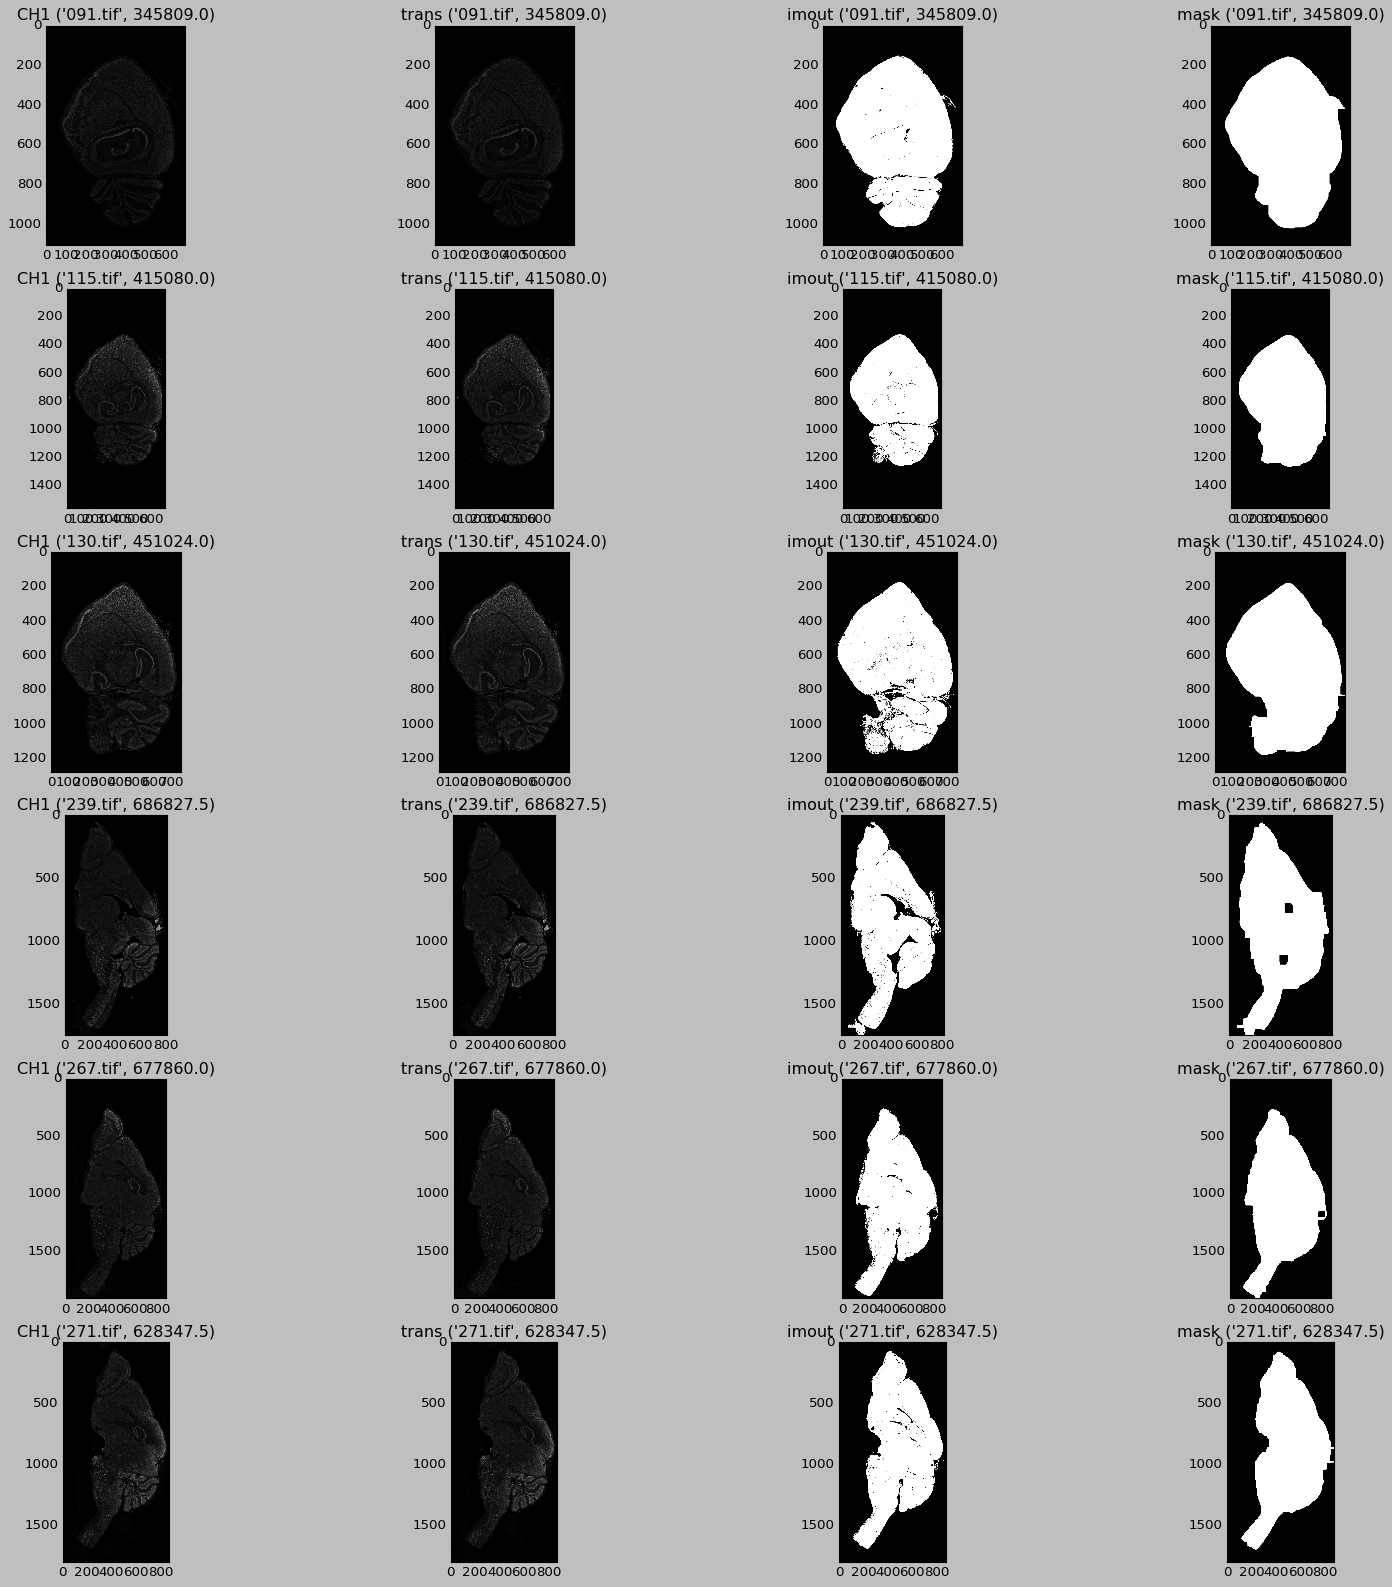

In [11]:
start, finish = (0,20)
#displays = masks[start:finish]
dins = img_inputs[start:finish]
douts = img_outputs[start:finish]
dmasks = masks[start:finish]
names = file_inputs[start:finish]
dimouts = imouts[start:finish]
ncols = 4
fig, ax = plt.subplots(nrows=len(names), ncols=ncols, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for filein,fileout,dimout, mask,name in zip(dins, douts, dimouts,dmasks, names):
    ax[i,0].set_title('CH1 {}'.format(name))
    ax[i,0].imshow(filein, cmap="gray")
    ax[i,1].set_title('trans {}'.format(name))
    ax[i,1].imshow(fileout, cmap="gray")
    ax[i,2].set_title('imout {}'.format(name))
    ax[i,2].imshow(dimout, cmap="gray")
    ax[i,3].set_title('mask {}'.format(name))
    ax[i,3].imshow(mask, cmap="gray")

    i += 1
# swap the 10 and the six below if the images are wider than height
fig.set_size_inches(np.array([6*ncols, 4 * len(names)]), forward=True)
plt.show()